# 3.2线性回归的从零开始实现
&emsp;&emsp;在本节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。虽然现代的深度学习框架几乎可以自动化地进行所有的这些工作，但从零开始实现可以确保我们真正直到自己在做什么。同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。在本节中，将只使用张量和自动求导。在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。

In [113]:
%matplotlib inline      
# 作用是让matplotlib生成的图直接显示在notebook中，而不是新的窗口
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集
&emsp;&emsp;为了简单起见，我们将根据带有噪声的线性模型构造一个数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。我们将使用低维数据，这样可以很容易地将其可视化。在下面的代码中，我们将生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中抽取的两个特征。我们的合成数据集是一个矩阵X∈R<sup>1000*2</sup>
我们使用线性模型参数w=[2,-3.4]<sup>T</sup>、b=4.2的噪声项ε来生成数据集及其标签：
<center>y=Xw+b+ε</center>
&emsp;&emsp;ε可以是为模型预测和标签的潜在观测误差。在这里我们是为标准假设成立，即ε服从均值为0的正态分布。为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。

In [114]:
def synthetic_data(w,b,num_examples):
    '''生成y=Xw+b+噪点'''
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [115]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

&emsp;&emsp;注意，features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值(一个标量)。

In [116]:
print('features=',features[0],'\nlabels=',labels[0])

features= tensor([1.8270, 2.0796]) 
labels= tensor([0.7698])


&emsp;&emsp;通过生成第二个特征features[:,1]和labels的散点图，可以直观地观察到两者之间的线性关系。

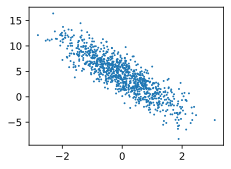

In [117]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

### 3.2.2 读取数据集
&emsp;&emsp;回想一下，训练模型时要对数据集进行遍历，每次抽取小批量样本，并使用它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，因此有必要定义一个函数，该函数能打乱数据集中的样本，并加以小批量方法获取数据。<br>
在下面的代码中，我们定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签。

In [118]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

&emsp;&emsp;直观感受一下小批量计算：读取第一个小批量数据样本并打印。每个批量的特征维度显示批量大小和输入特征数。同样，批量的标签形状与batch_size相等。

In [119]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.4456, -0.8486],
        [-1.1967, -0.9069],
        [-0.2230, -1.4864],
        [-0.4698, -0.1482],
        [-0.5118,  1.9136],
        [-1.4795,  1.1692],
        [ 0.3014,  0.6308],
        [ 1.3792, -1.2707],
        [ 0.9613, -0.9216],
        [-0.1076,  0.1215]]) 
 tensor([[ 7.9723],
        [ 4.8706],
        [ 8.8205],
        [ 3.7706],
        [-3.3171],
        [-2.7238],
        [ 2.6502],
        [11.2741],
        [ 9.2546],
        [ 3.5694]])


### 3.2.3 初始化模型参数
&emsp;&emsp;在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。在下面的代码中，我们通过从均值为0，标准差为0.01的正态分布中抽样随机数来初始化权重，并将偏置初始化为0。

In [120]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

&emsp;&emsp;在初始化参数之后，我们的任务是更新这些参数，直到这些参数足以拟合我们的数据。每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。因为手动计算梯度很枯燥而且容易出错，所有没有人会手动计算梯度。我们使用自动微分来计算梯度。

### 3.2.4 定义模型
&emsp;&emsp;接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。回想一下，要计算线性模型的输出，我们只需计算输入特征<b>X</b>和模型权重<b>w</b>的矩阵-向量乘法后加上偏置b。注意，<b>Xw</b>是一个向量，而b是一个标量。回想一下广播机制：当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [121]:
def linreg(X,w,b):
    '''线性回归模型'''
    return torch.matmul(X,w)+b

### 3.2.5定义损失函数
&emsp;&emsp;因为需要计算损失函数的梯度，所以我们应该先定义损失函数，这里使用3.1中的平方损失函数。在实现中，我么们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [122]:
def squared_loss(y_hat,y):
    '''均方误差'''
    return (y_hat - y.reshape(y_hat.shape))**2/2

### 3.2.6 定义优化函数
&emsp;&emsp;线性回归有解析解，但是其他模型没有，这里我们介绍小批量随机梯度下降。
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习率和批量大小作为输入。每一步更新的大小由学习率<b>lr</b>决定。因为我们计算的损失时一个批量样本的总和，所以我们用批量大小(batch size)来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [123]:
def sgd(params,lr,batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

### 3.2.7 训练
&emsp;&emsp;现在我们已经准备好了模型训练所需的要素，可以实现主要的训练过程过分了。理解这段代码至关重要，因为从事深度学习后，相同的训练过程几乎一遍又一遍地出现。在每次迭代中，我们读取小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法sgd来更新模型参数。
<br>概括一下，我们将执行以下迭代。<br>
&emsp;&emsp;(1)初始化参数。<br>
&emsp;&emsp;(2)重复以下训练，直到完成：<br>
&emsp;&emsp;&emsp;·计算梯度g⬅∂<sub>(w,b)</sub>1/|B|∑l(x<sup>(i)</sup>,y<sup>(i)</sup>,w,b)；<br>
&emsp;&emsp;&emsp;·更新参数(w,b)⬅(w,b)-ηg。
&emsp;&emsp;在每轮(epoch)中，我们使用data_iter函数遍历整个数据集，并将训练数据集中的所有样本都使用一次(假设样本数能够被批量大小整除)。这里的轮数num_epochs和学习率lr都是超参数，分别设为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。我们现在忽略这些细节，以后会在第11章详细介绍。

In [124]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [125]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)  # X和y的小批量损失
        # 因为l的形状是(batch_size,1)，而不是一个标量
        # l中的所有元素被加到一起，并以此计算[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.042170
epoch2, loss 0.000171
epoch3, loss 0.000050


&emsp;&emsp;比较真实参数和训练的参数来评估训练的成功程度。

In [126]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的误差值：{true_b-b}')

w的估计误差：tensor([ 0.0002, -0.0006], grad_fn=<SubBackward0>)
b的误差值：tensor([0.0008], grad_fn=<RsubBackward1>)


&emsp;&emsp;在机器学习中，我们通常不关心恢复真实的参数，而更关心如何高度准确地预测参数。幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常令人满意的解。其中的一个原因就是：在深度网络中存在许多参数组合能够实现高度准确的预测。